In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Apenas matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Carregar dados
df = pd.read_csv('NFLX.csv')

# Converter data e ORDENAR
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Resetar o índice
df = df.reset_index(drop=True)

# Visualizar
print(df.head())

        Date        Open        High         Low       Close   Adj Close  \
0 2023-02-01  353.859985  365.390015  349.910004  361.989990  361.989990   
1 2023-02-02  365.160004  368.320007  358.429993  366.890015  366.890015   
2 2023-02-03  359.079987  379.429993  359.000000  365.899994  365.899994   
3 2023-02-06  363.640015  368.450012  360.679993  361.480011  361.480011   
4 2023-02-07  358.510010  364.179993  354.179993  362.950012  362.950012   

    Volume  
0  8005200  
1  7857000  
2  9402000  
3  4994900  
4  6289400  


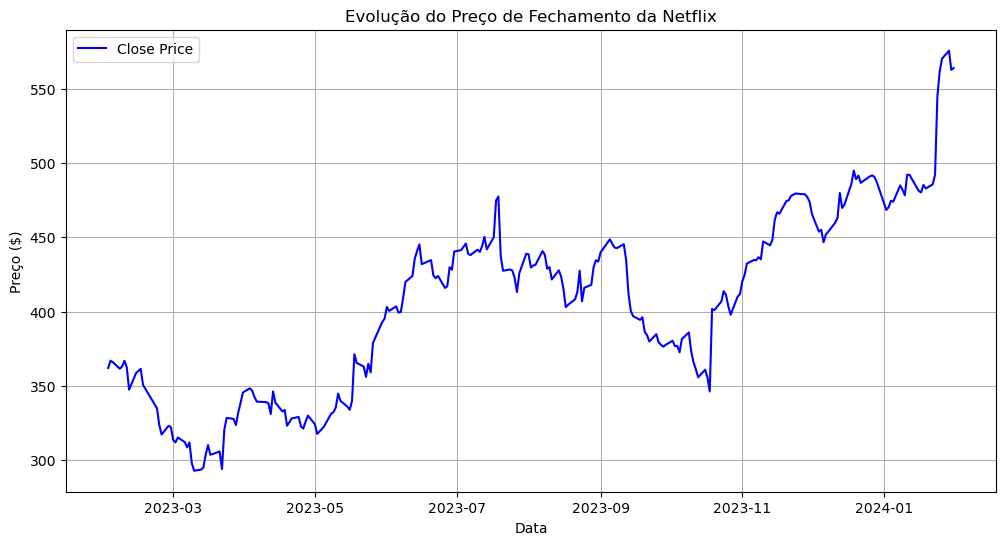

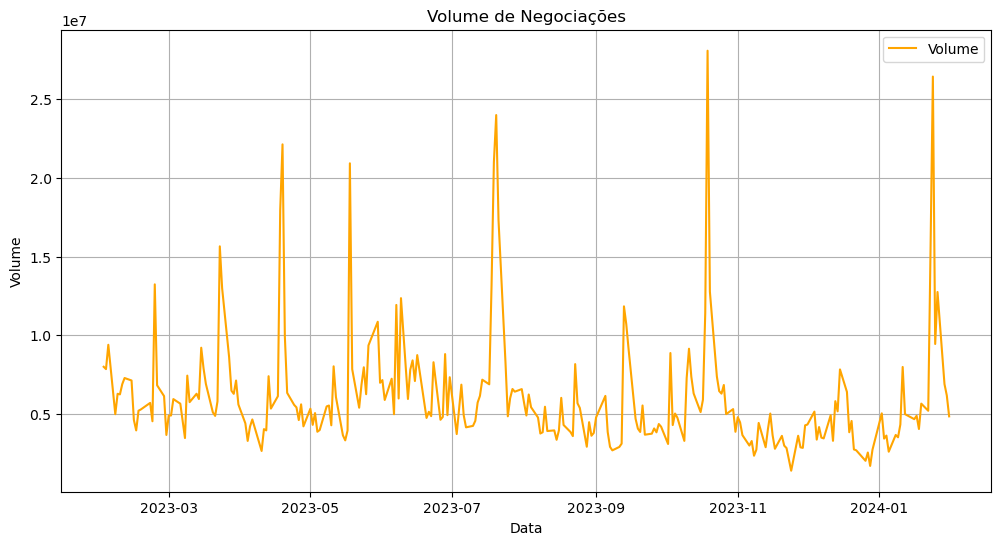

In [3]:
# Gráfico de Preço
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('Evolução do Preço de Fechamento da Netflix')
plt.xlabel('Data')
plt.ylabel('Preço ($)')
plt.grid(True) # Adiciona grade manual já que tiramos o sns.set()
plt.legend()
plt.show()

# Gráfico de Volume
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Volume'], color='orange', label='Volume')
plt.title('Volume de Negociações')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
# Variável derivada: Preço de Fechamento do dia ANTERIOR (Lag 1)
df['Close_Ontem'] = df['Close'].shift(1)

# Remover a primeira linha (NaN)
df_limpo = df.dropna().copy()

# Definir X (Entradas) e y (Saída)
variaveis = ['Open', 'High', 'Low', 'Volume', 'Close_Ontem']
alvo = 'Close'

X = df_limpo[variaveis]
y = df_limpo[alvo]

In [6]:
# Índice de corte (80% treino)
tamanho_treino = int(len(df_limpo) * 0.8)

# Fatiamento manual
X_train = X.iloc[:tamanho_treino]
y_train = y.iloc[:tamanho_treino]

X_test = X.iloc[tamanho_treino:]
y_test = y.iloc[tamanho_treino:]

print(f"Dados de Treino: {X_train.shape[0]}")
print(f"Dados de Teste: {X_test.shape[0]}")

Dados de Treino: 200
Dados de Teste: 50


In [7]:
# Instanciar e ajustar APENAS no treino
scaler = MinMaxScaler()
scaler.fit(X_train)

# Transformar
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [8]:
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)

# Prever
y_pred_lr = modelo_lr.predict(X_test)

# Avaliar
r2_lr = r2_score(y_test, y_pred_lr)
print(f"R² Regressão Linear: {r2_lr:.4f}")

R² Regressão Linear: 0.9892


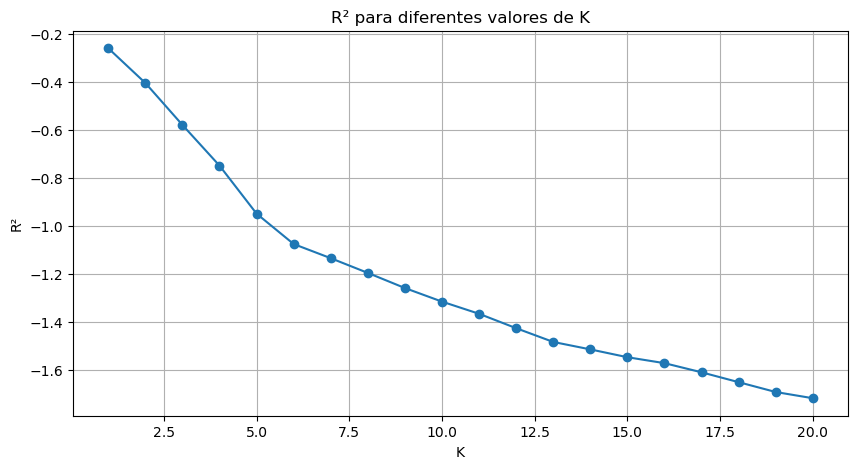

Melhor K escolhido: 1
R² KNN (K=1): -0.2578


In [9]:
lista_k = range(1, 21)
scores_k = []

for k in lista_k:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_norm, y_train)
    score = knn.score(X_test_norm, y_test)
    scores_k.append(score)

# Gráfico da escolha do K
plt.figure(figsize=(10, 5))
plt.plot(lista_k, scores_k, marker='o')
plt.title('R² para diferentes valores de K')
plt.xlabel('K')
plt.ylabel('R²')
plt.grid(True)
plt.show()

# Melhor K
melhor_k = lista_k[np.argmax(scores_k)]
print(f"Melhor K escolhido: {melhor_k}")

# Modelo Final KNN
modelo_knn = KNeighborsRegressor(n_neighbors=melhor_k)
modelo_knn.fit(X_train_norm, y_train)
y_pred_knn = modelo_knn.predict(X_test_norm)

r2_knn = r2_score(y_test, y_pred_knn)
print(f"R² KNN (K={melhor_k}): {r2_knn:.4f}")

--- Resultado Final ---
Regressão Linear R²: 0.9892
KNN R²: -0.2578
O melhor modelo foi: Regressão Linear


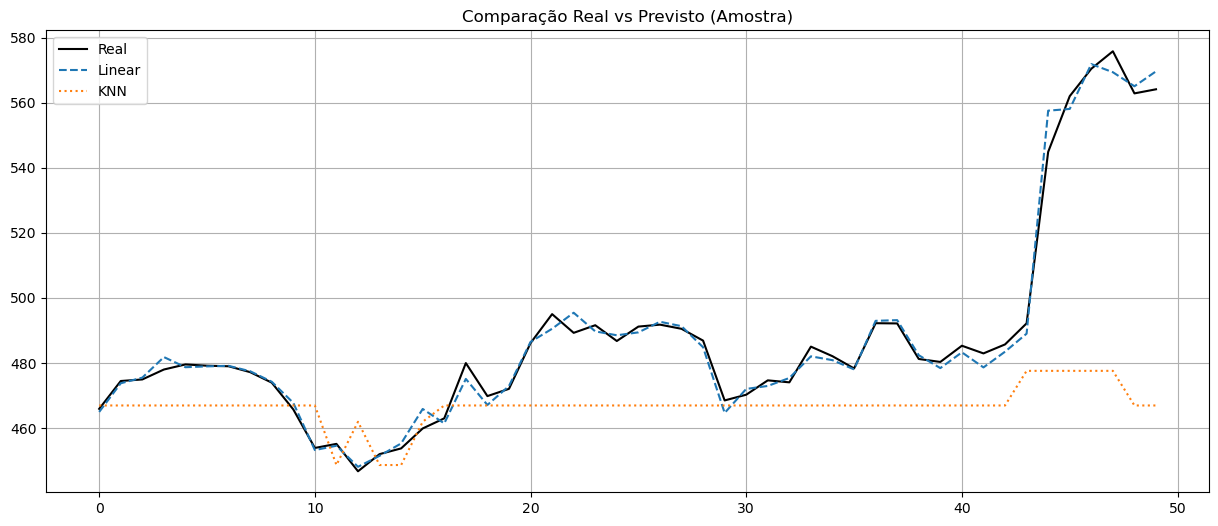

In [10]:
print("--- Resultado Final ---")
print(f"Regressão Linear R²: {r2_lr:.4f}")
print(f"KNN R²: {r2_knn:.4f}")

if r2_lr > r2_knn:
    print("O melhor modelo foi: Regressão Linear")
    melhores_previsoes = y_pred_lr
else:
    print("O melhor modelo foi: KNN")
    melhores_previsoes = y_pred_knn

# Gráfico comparativo
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:50], label='Real', color='black')
plt.plot(y_pred_lr[:50], label='Linear', linestyle='--')
plt.plot(y_pred_knn[:50], label='KNN', linestyle=':')
plt.legend()
plt.grid(True)
plt.title("Comparação Real vs Previsto (Amostra)")
plt.show()

In [11]:
df_resultado = pd.DataFrame({'price': melhores_previsoes})
df_resultado['price'] = df_resultado['price'].round(2)

df_resultado.to_csv('precos_estimados.csv', index=False)
print("Arquivo salvo com sucesso!")

Arquivo salvo com sucesso!
